## Описание проекта

Одна из компаний собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Содержание  <a class="anchor" id="0-bullet">
* [1. Подготовка данных](#1-bullet)
* [2. Анализ данных](#2-bullet)
* [3. Обучение и тестирование моделей](#3-bullet)
    * [3.1. Линейная регрессия](#3.1-bullet)
    * [3.2. Решающее дерево](#3.2-bullet)
    * [3.3. Случайный лес](#3.3-bullet)
    * [3.4. LGBMRegressor](#3.4-bullet)

# 1. Подготовка данных<a class="anchor" id="1-bullet"></a>

<span style="color:purple">Вызовем необходимые библиотеки, откроем файлы данных и изучим обшую информацию.<span>

In [44]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# считаем файлы данных, сделаем дату индексом и отсортируем данные
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

#  выведем информацию для загруженной таблицы
print(data.info())
display(pd.concat([data.head(2), data.tail(3)]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<span style="color:purple">В таблице представлены данные о заказах такси, сделанных с марта по август 2018 года с периодичностью в 10 мин.

<span style="color:purple">Выполним ресемплирование данных (периодичность - 1 час).

In [45]:
data = data.resample('1H').sum()

<span style="color:purple">Посмотрим, что получилось.

In [46]:
display(pd.concat([data.head(2), data.tail(3)]))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<span style="color:purple">Данные подготовлены, переходим к анализу.

# 2. Анализ данных<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

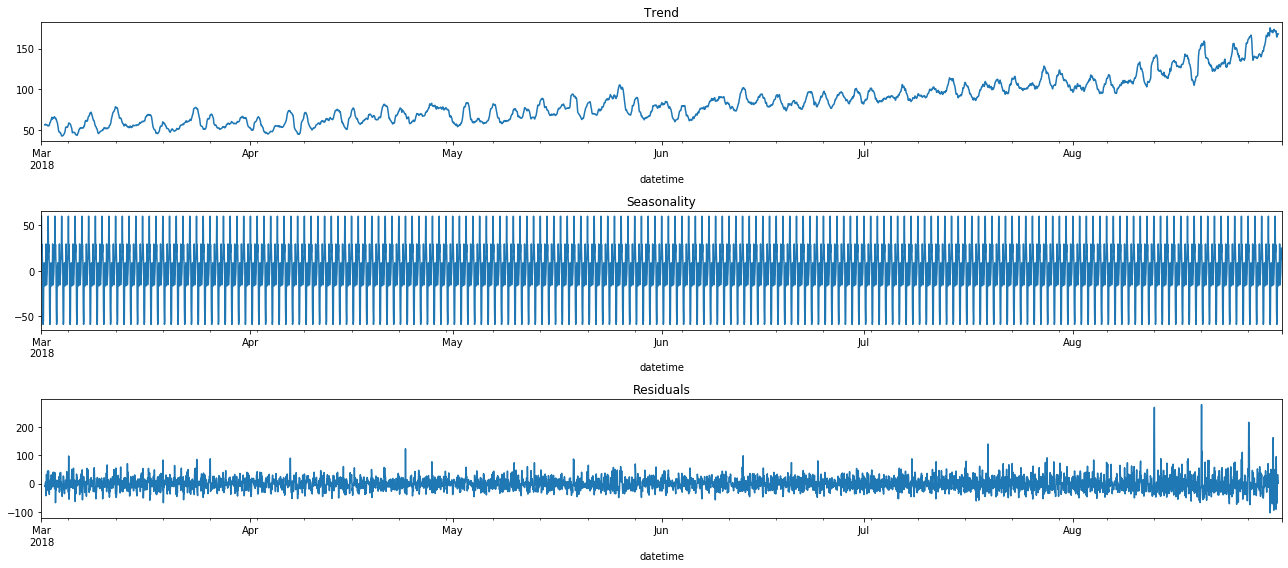

In [47]:
decomposed = seasonal_decompose(data['num_orders'], model='additive')
plt.figure(figsize=(18, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<span style="color:purple">Виден восходящий тренд, но в таком виде всё не слишком наглядно, особенно с сезонностью. Сделаем иное ресемплирование - с периодичностью в один день, и посмотрим, что получилось. Добавим также скользящее среднее.

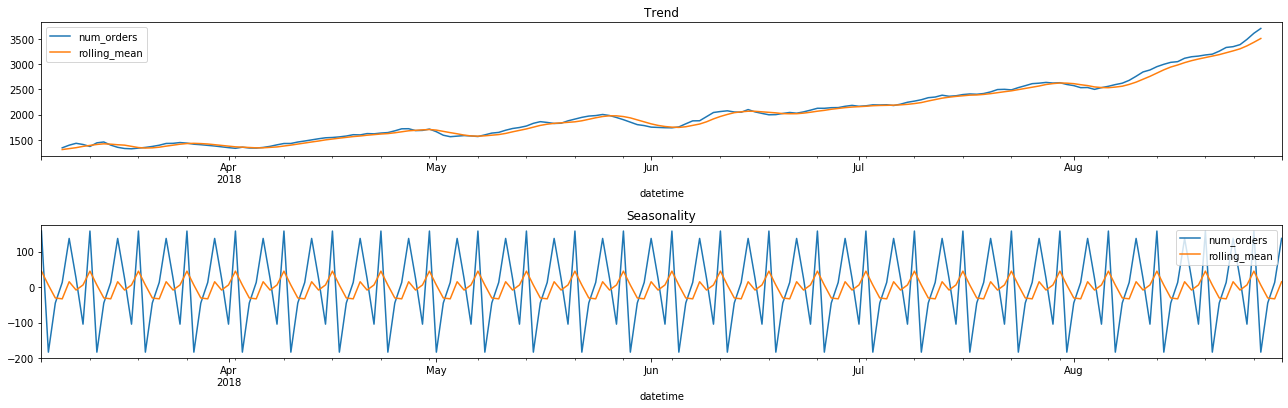

In [48]:
data_day = data.resample('1D').sum()
data_day['rolling_mean'] = data_day['num_orders'].rolling(5).mean()
data_day = data_day.dropna()

decomposed_day = seasonal_decompose(data_day)
plt.figure(figsize=(18, 8))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

<span style="color:purple">Здесь уже явно видна сезонность. Но чтобы точнее понять, в чём она заключается, посмотрим данные за три недели.

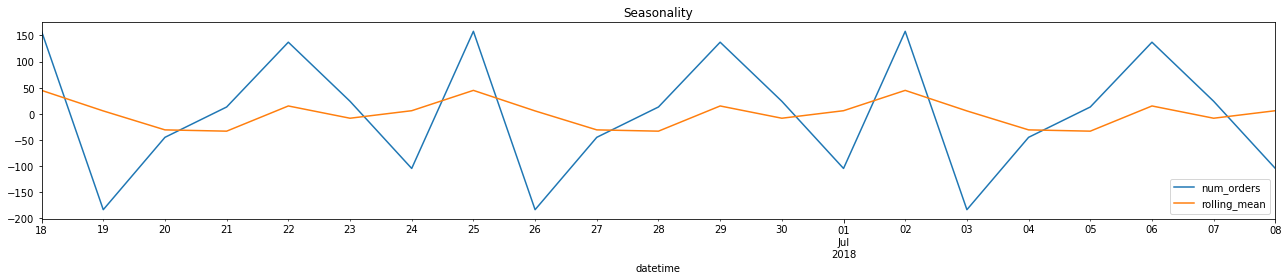

In [49]:
plt.figure(figsize=(18, 4))
decomposed_day.seasonal['2018-06-18':'2018-07-08'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

<span style="color:purple">Больше всего такси заказывают в понедельник. В пятницу спрос также достаточно высокий. А вот в воскресенье и особенно во вторник такси наименее востребованы.

<span style="color:purple">Проанализируем данные за два дня, чтобы понять распределение заказов внутри дня.

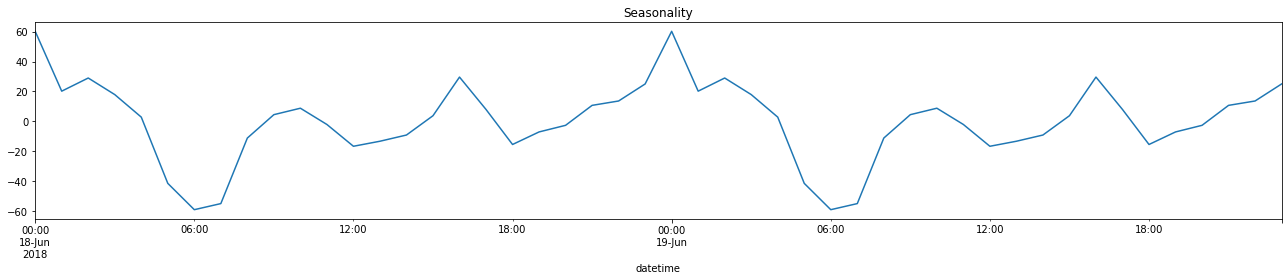

In [50]:
decomposed_new = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(18, 4))
decomposed_new.seasonal['2018-06-18':'2018-06-19'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

<span style="color:purple">Как мы видим, пик заказов приходится на 12 часов ночи, а в 6 утра заказов меньше всего. С некоторыми оговорками можно сказать, что с 6 утра до 12 часов ночи наблюдается восходящий тренд.

# 3. Обучение и тестирование моделей<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Напишем функцию, которая добавит дополнительные признаки в датасет. Будем добавлять календарные признаки (месяц, день, час, день недели, выходной/будний день, признаки времени суток (ночь, утро, день и вечер), а также отстающие значения и скользящее среднее.

In [51]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['weekend'] = data.dayofweek.isin([5,6])*1
    data['night'] = (data['hour'].isin([23, 0, 1, 2, 3, 4])).astype(np.int32)
    data['morning'] = (data['hour'].isin([5, 6, 7, 8, 9, 10])).astype(np.int32)
    data['afternoon'] = (data['hour'].isin([11, 12, 13, 14, 15, 16])).astype(np.int32)
    data['evening'] = (data['hour'].isin([17, 18, 19, 20, 21, 22])).astype(np.int32)

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [52]:
make_features(data, 48, 5)
print(data.info())
display(pd.concat([data.head(2), data.tail(3)]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 59 columns):
num_orders      4368 non-null int64
month           4368 non-null int64
day             4368 non-null int64
hour            4368 non-null int64
dayofweek       4368 non-null int64
weekend         4368 non-null int64
night           4368 non-null int32
morning         4368 non-null int32
afternoon       4368 non-null int32
evening         4368 non-null int32
lag_1           4368 non-null float64
lag_2           4368 non-null float64
lag_3           4368 non-null float64
lag_4           4368 non-null float64
lag_5           4368 non-null float64
lag_6           4368 non-null float64
lag_7           4368 non-null float64
lag_8           4368 non-null float64
lag_9           4368 non-null float64
lag_10          4368 non-null float64
lag_11          4368 non-null float64
lag_12          4368 non-null float64
lag_13          4368 non-null flo

,num_orders,month,day,hour,dayofweek,weekend,night,morning,afternoon,evening,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,0,5,1,1,0,0,0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,86.8
2018-03-03 01:00:00,108,3,3,1,5,1,1,0,0,0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,109.6
2018-08-31 21:00:00,159,8,31,21,4,0,0,0,0,1,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,182.2
2018-08-31 22:00:00,223,8,31,22,4,0,0,0,0,1,...,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,174.6
2018-08-31 23:00:00,205,8,31,23,4,0,1,0,0,0,...,39.0,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,175.8


<span style="color:purple">Создадим переменные для признаков и целевого признака.

In [53]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

<span style="color:purple">Разделим данные на обучающую и тестовую выборки (в соотношении 9:1)

In [54]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle = False, test_size = 0.1)

In [55]:
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(3931, 58)

(437, 58)

(3931,)

(437,)

<span style="color:purple">Будем использовать кросс-валидацию на скользящем окне для временных рядов.

In [56]:
ts_cv = TimeSeriesSplit(n_splits=5)

<span style="color:purple">Лучшие параметры для моделей будем подбирать с помощью GridSearchCV.

<span style="color:purple">Напишем функцию, вычисляющую rmse:

In [57]:
def rmse(target, predictions):
    rmse = mean_squared_error(target, predictions) ** 0.5
    return rmse

In [58]:
rmse_scorer = make_scorer(rmse, greater_is_better = False)

## 3.1. Линейная регрессия<a class="anchor" id="3.1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [59]:
%%time
param_liner = {'copy_X':[True, False], 'fit_intercept':[True, False], 'normalize':[True, False]}

gs_liner = GridSearchCV(LinearRegression(), param_liner, cv = ts_cv, scoring = rmse_scorer)
gs_liner.fit(features_train, target_train)
liner_params = gs_liner.best_params_
display(liner_params)

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

CPU times: user 4.99 s, sys: 5.29 s, total: 10.3 s
Wall time: 10.3 s


<span style="color:purple">Обучим модель на наилучших параметрах и сделаем предсказание на тестовой выборке.

In [60]:
liner = LinearRegression(**liner_params)
liner.fit(features_train, target_train)
predictions = liner.predict(features_test)
smape_liner = rmse(target_test, predictions)
display(smape_liner)

42.227834894988476

## 3.2. Решающее дерево<a class="anchor" id="3.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [61]:
%%time
param_tree =  {'max_depth': [3, 4, 5, 6], 'min_samples_split': [7, 9, 11]}

gs_tree = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_tree, cv = ts_cv, scoring = rmse_scorer)
gs_tree.fit(features_train, target_train)
tree_params = gs_tree.best_params_
display(tree_params)

{'max_depth': 5, 'min_samples_split': 9}

CPU times: user 2.31 s, sys: 8.4 ms, total: 2.32 s
Wall time: 2.38 s


<span style="color:purple">Обучим модель на наилучших параметрах и сделаем предсказание на тестовой выборке.

In [62]:
tree = DecisionTreeRegressor(**tree_params, random_state = 12345)
tree.fit(features_train, target_train)
predictions = tree.predict(features_test)
smape_tree = rmse(target_test, predictions)
display(smape_tree)

50.533935552338214

## 3.3. Случайный лес<a class="anchor" id="3.3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [63]:
%%time
param_forest = {'max_depth': [18, 20], 'min_samples_split': [4, 5, 6]}

gs_forest = GridSearchCV(RandomForestRegressor(random_state = 12345, n_estimators = 80), param_forest, cv = ts_cv, \
                         scoring = rmse_scorer)
gs_forest.fit(features_train, target_train)
forest_params = gs_forest.best_params_
display(forest_params)

{'max_depth': 20, 'min_samples_split': 5}

CPU times: user 2min 22s, sys: 0 ns, total: 2min 22s
Wall time: 2min 22s


<span style="color:purple">Обучим модель на наилучших параметрах и сделаем предсказание на тестовой выборке.

In [64]:
forest = RandomForestRegressor(**forest_params, random_state = 12345, n_estimators = 80)
forest.fit(features_train, target_train)
predictions = forest.predict(features_test)
rmse_forest = rmse(target_test, predictions)
display(rmse_forest)

41.6815477401962

## 3.4. LGBMRegressor<a class="anchor" id="3.4-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [65]:
%%time
param_lgbm = {'max_depth': [4, 5, 6], 'learning_rate': [0.1, 0.2], 'n_estimators': [120, 150]}

gs_lgbm = GridSearchCV(LGBMRegressor(random_state=12345), param_lgbm, scoring = rmse_scorer, cv = ts_cv)
gs_lgbm.fit(features_train, target_train)
LGBM_params = gs_lgbm.best_params_
display(LGBM_params)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 120}

CPU times: user 1min 33s, sys: 1.24 s, total: 1min 34s
Wall time: 1min 35s


<span style="color:purple">Обучим модель на наилучших параметрах и сделаем предсказание на тестовой выборке.

In [66]:
lgbm = LGBMRegressor(**LGBM_params, random_state=12345)
lgbm.fit(features_train, target_train)
predictions = lgbm.predict(features_test)
rmse_lgbm = rmse(target_test, predictions)
display(rmse_lgbm)

39.71664300216922

<span style="color:purple">Таким образом, лучшую rmse показала модель LGBMRegressor. На тестовых данных достигнуто значение rmse = 39.72